In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install tf2cv tensorflow>=2.0.0

In [3]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11870491563669515717
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [0]:
#global consts
IMG_SIZE='137x236'
HEIGHT = 137
WIDTH = 236
BATCH_SIZE=128
DROP_OUT=0.0
FOLD=0
TRAIN_DIR = './train/'
TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 200
STATS_FS = (0.055029564364430086, 0.17228061284674265)
STATS_FS_CMB = (0.09286854353548928, 0.2590057461393323)
STATS_FS_CMB_FULL = (0.10691752301104243, 0.28251506457722886)
STATS_128 = (0.0692, 0.2051)
EXPERIMENT='sernext_3cmc_fullsize_COMBY_wo_od'
INPUT_DIR ='/content/drive/My Drive/kaggle/bengali/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/bengali/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/bengali/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = 'distrib/'
DATASET_224='224x224-bengali.zip'
DATASET_128='grapheme-imgs-128x128.zip'
DATASET_FS = 'bengali-full-size.zip'
DATASET_FS_CMB = 'bengalicomby.zip'
DATASET_FS_CMB_FULL = 'banglacomby-full.zip'
TRAIN_WITH_FOLD = 'train_with_fold_20.csv'
BANGLA_MAP = 'bangla_map.csv'
BANGLA_MAP_FULL =  'bangla_map_full.csv'
PRETRAINED = True
PRETRAINED_WEIGHTS = 'w_kr_0.9908.h5'
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'
#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

if IMG_SIZE == 128: DATASET=DATASET_128
if IMG_SIZE == 224: DATASET=DATASET_224
if IMG_SIZE == '137x236' : DATASET=DATASET_FS_CMB_FULL


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [0]:
#import local modules
#from mish import Mish,mish
from generators import *
from kaggle_metric import *
#from cosine import CosineAnnealingScheduler
from kagglevalidation import KaggleValidationFS
#from lookahead import Lookahead
from se_resnext50 import build_se_resnext50_model_fs_wod
#from md121v2 import build_md121_v2_model
#from losses import categorical_focal_loss


#import external modules
import numpy as np 
import pandas as pd 

import os
import errno

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [8]:
try:
  os.mkdir(TRAIN_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_DIR+' already exists')
    else:
        raise
try:
  os.mkdir(TRAIN_IMG_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_IMG_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise


os.system('cp '+ '"'+INPUT_DIR+DATASET+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+BANGLA_MAP_FULL+'" ' + TRAIN_DIR)


/content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/ already exists
/content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ already exists


0

In [0]:
if PRETRAINED: os.system('cp '+ '"'+EXPERIMENT_DIR+PRETRAINED_WEIGHTS+'" '+TRAIN_DIR)

In [11]:
os.system('unzip -q '+TRAIN_DIR+DATASET+ ' -d '+ TRAIN_IMG_DIR)

0

In [10]:
!ls train

137x236		      bangla_map_full.csv     w_kr_0.9908.h5
banglacomby-full.zip  train_with_fold_20.csv


In [0]:
dataset_np = pd.read_csv(TRAIN_DIR+TRAIN_WITH_FOLD).to_numpy()
bangla_map_np = pd.read_csv(TRAIN_DIR+BANGLA_MAP_FULL).to_numpy()
bangla_map_np = np.c_[bangla_map_np,np.ones((bangla_map_np.shape[0],3), dtype=int)]

dataset_np = np.r_[dataset_np, bangla_map_np]
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]


valid_m = np.where(dataset_np[:,6]==FOLD)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != FOLD)
fold_valid_inds = np.where(dataset_np[:,6] == FOLD)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
cons_unique=np.unique(train_np[:,3])
cons_y_train = train_np[:,3]
vowel_unique=np.unique(train_np[:,2])
vowel_y_train = train_np[:,2]
root_unique =np.unique(train_np[:,1])
root_y_train = train_np[:,1]

cons_class_weights = class_weight.compute_class_weight('balanced',
                                                 cons_unique,
                                                 cons_y_train)

vowel_class_weights = class_weight.compute_class_weight('balanced',
                                                 vowel_unique,
                                                 vowel_y_train)

root_class_weights = class_weight.compute_class_weight('balanced',
                                                 root_unique,
                                                 root_y_train)
cons_cw_dict=dict(enumerate(cons_class_weights))
vowel_cw_dict=dict(enumerate(vowel_class_weights))
root_cw_dict=dict(enumerate(root_class_weights))

model_cw={}
model_cw['root']=root_cw_dict
model_cw['vowel']=vowel_cw_dict
model_cw['consonant']=cons_cw_dict

In [0]:
model =  build_se_resnext50_model_fs_wod(height=HEIGHT, width=WIDTH)

In [0]:
if 0: model.summary()

In [0]:
if 0:
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file=OUTPUT_DIR+'model3.png',show_shapes=True)

In [0]:
if 0:
  for (n, layer) in enumerate(model.layers[1].layers):
    if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
      print('replacing #{}: {}, {}'.format(n, layer, layer.activation))
      layer.activation = Mish(mish)
      print('-> {}'.format(layer.activation))

In [14]:
TRAIN_DIR+PRETRAINED_WEIGHTS

'./train/w_kr_0.9908.h5'

In [0]:
cutout_datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(p=0.95,s_l=0.05,s_h=0.3,r_1=0.8,r_2=1.2,v_l=0,v_h=0))

mcm_datagen = ImageDataGenerator()

In [16]:
columns=["root_class","vowel_class", "cons_class"]

mcm_generator1 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

mcm_generator2 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")


cutout_generator = cutout_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

Found 329230 validated image filenames.
Found 329230 validated image filenames.
Found 329230 validated image filenames.


In [0]:
def g3_generator_fs2(gen1,gen2, gen3,h=137,w=236,st=STATS_FS):
    while True:
        p = np.random.rand()
        if p>0.8:
            batch = next(gen3)
            x_res,y_res = prep_batch_fs(batch,st=st)
        else:
            batch1 = next(gen1)
            batch2 = next(gen2)
            q = np.random.rand()
            if q>0.3:
                x_res,y_res = mix_batches_fs(batch1,batch2,alpha=0.1,st=st)
            else:
                x_res,y_res = cutmix_batches_fs2(batch1,batch2,alpha=0.8,h=h,w=w,st=st)
        yield x_res,y_res

In [0]:
if 0:
  mixup_datagen=mixup_data_gen(aux_data_gen(mcm_generator1),aux_data_gen(mcm_generator2))
  cutout_datagen=aux_data_gen(cutout_generator)
  h_datagen=hybrid_data_gen(mixup_datagen,cutout_datagen)
  h2_datagen=h_generator(mcm_generator1,mcm_generator2,cutout_generator)
  hmcm_datagen=hmcm_generator(mcm_generator1,mcm_generator2)
  g3_datagen = g3_generator(mcm_generator1,mcm_generator2,cutout_generator)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)
  cpsm_datagen_fs = cpsm_generator_fs(mcm_generator1,mcm_generator2,cutout_generator, st=STATS_FS)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)

g3_datagen_fs2 = g3_generator_fs2(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS_CMB_FULL)

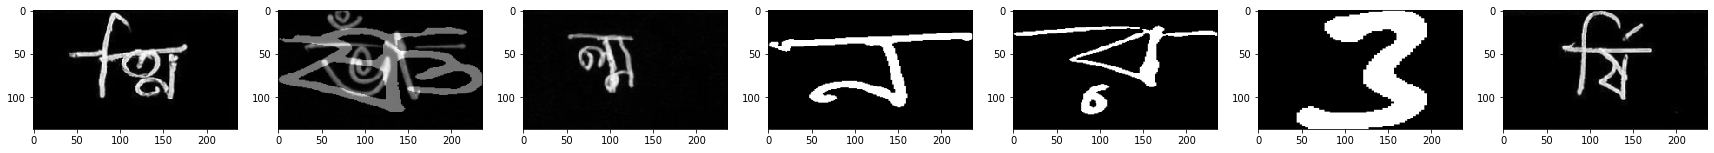

In [21]:
if 1: 
  batch_x,y = next(g3_datagen_fs2)
  import matplotlib.pyplot as plt
  fig, axs = plt.subplots(1, 7, figsize=(30, 30))
  for i in range(7):
    axs[i].imshow(batch_x[i,:,:,0], cmap='gray')
  plt.show()

In [0]:
if 0: opt = Lookahead(tf.keras.optimizers.SGD(learning_rate=LR_MAX, momentum=0.9,nesterov=True))

opt=tf.keras.optimizers.Adam(learning_rate=LR_MAX)

In [0]:
checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)

In [0]:
chkp_manager.latest_checkpoint

In [31]:
chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
if chkp_manager.latest_checkpoint:
  #chkp_restore_status.assert_consumed()
  print("Restored from {}".format(chkp_manager.latest_checkpoint))
  print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
else:
  print("Initializing from scratch.")

Initializing from scratch.


In [0]:
loss_dict={'root':    'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[2.0,1.0,1.0])

In [0]:
if PRETRAINED: model.load_weights(TRAIN_DIR+PRETRAINED_WEIGHTS)

In [0]:
initial_epoch = checkpoint.latest_epoch.numpy()

print(f'epochs trained: {initial_epoch}. start training epoch {initial_epoch+1}...')
#ca_shed = CosineAnnealingScheduler(T_max=T_MAX, eta_max=LR_MAX, eta_min=LR_MIN,verbose=1, initial_epoch=initial_epoch-130)
#rolrplt = tf.keras.callbacks.ReduceLROnPlateau(monitor='kaggle',mode='max', patience=5, verbose=1, factor=0.5, min_lr=LR_MIN)


suffix =EXPERIMENT+\
                '_eps'+str(EPOCHS)+\
                '_iniep'+str(initial_epoch)+\
                '_sz'+str(IMG_SIZE)+\
                '_bs'+str(BATCH_SIZE)+\
                '_do'+str(DROP_OUT)+\
                '_'+model.optimizer.get_config()['name']+\
                '_IS_fold'+str(FOLD)


kv = KaggleValidationFS(valid_df,
                      batch_size=512,
                      vals_per_epoch=8,
                      train_steps=train_m//BATCH_SIZE+1,
                      logfile=EXPERIMENT_DIR+'log_kr_'+suffix+'.csv',
                      initial_epoch=initial_epoch,
                      suffix = suffix,
                      train_img_dir=TRAIN_IMG_DIR,
                      output_dir=EXPERIMENT_DIR,
                      thresholds=[0.987,0.995,0.995],
                      chkp_manager=chkp_manager,
                      in_shape=[HEIGHT,WIDTH],
                      st=STATS_FS_CMB_FULL)

tf.keras.backend.set_value(model.optimizer.lr, 0.0001)
cbs = [kv]

history=model.fit(g3_datagen_fs2,
                  epochs=EPOCHS,
                  steps_per_epoch=train_m//BATCH_SIZE+1,
                  callbacks=cbs,
                  #class_weight=model_cw,
                  verbose=2)

epochs trained: 0. start training epoch 1...
Train for 2573 steps
Epoch 1/200

batch 320: validation...



[0:06:09] - kaggle:0.9831 - root:0.9764 -vowel:0.9889 - cons: 0.9908

batch 641: validation...



[0:11:31] - kaggle:0.9839 - root:0.9777 -vowel:0.9894 - cons: 0.9907

batch 962: validation...



[0:16:52] - kaggle:0.9851 - root:0.9796 -vowel:0.9905 - cons: 0.9906

batch 1283: validation...



[0:22:13] - kaggle:0.9849 - root:0.9789 -vowel:0.9907 - cons: 0.9912

batch 1604: validation...



[0:27:35] - kaggle:0.9852 - root:0.9793 -vowel:0.9918 - cons: 0.9905

batch 1925: validation...



[0:32:56] - kaggle:0.9864 - root:0.9809 -vowel:0.9931 - cons: 0.9907

batch 2246: validation...



[0:38:18] - kaggle:0.9861 - root:0.9807 -vowel:0.9926 - cons: 0.9906

batch 2567: validation...



[0:43:39] - kaggle:0.9856 - root:0.9798 -vowel:0.9922 - cons: 0.9905

saved checkpoint for epoch 1: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-1

2573/2573 - 2627s - loss: 2.0875 - root_loss: 0.6536 - vowel_loss: 0.2161 - consonant_loss: 0.1177
Epoch 2/200

batch 320: validation...



[0:49:08] - kaggle:0.9860 - root:0.9799 -vowel:0.9937 - cons: 0.9906

batch 641: validation...



[0:54:29] - kaggle:0.9872 - root:0.9828 -vowel:0.9923 - cons: 0.9909

batch 962: validation...



[0:59:50] - kaggle:0.9871 - root:0.9820 -vowel:0.9936 - cons: 0.9907

batch 1283: validation...



[1:05:11] - kaggle:0.9864 - root:0.9807 -vowel:0.9930 - cons: 0.9913

batch 1604: validation...



[1:10:32] - kaggle:0.9864 - root:0.9803 -vowel:0.9936 - cons: 0.9916

batch 1925: validation...



[1:15:53] - kaggle:0.9876 - root:0.9824 -vowel:0.9941 - cons: 0.9913

batch 2246: validation...



[1:21:15] - kaggle:0.9876 - root:0.9827 -vowel:0.9936 - cons: 0.9913

batch 2567: validation...



[1:26:36] - kaggle:0.9880 - root:0.9834 -vowel:0.9938 - cons: 0.9915

saved checkpoint for epoch 2: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-2

2573/2573 - 2577s - loss: 1.7107 - root_loss: 0.8948 - vowel_loss: 0.3046 - consonant_loss: 0.1969
Epoch 3/200

batch 320: validation...



[1:32:05] - kaggle:0.9867 - root:0.9814 -vowel:0.9928 - cons: 0.9911

batch 641: validation...



[1:37:26] - kaggle:0.9877 - root:0.9830 -vowel:0.9932 - cons: 0.9915

batch 962: validation...



[1:42:47] - kaggle:0.9864 - root:0.9801 -vowel:0.9938 - cons: 0.9914

batch 1283: validation...



[1:48:08] - kaggle:0.9878 - root:0.9827 -vowel:0.9936 - cons: 0.9922

batch 1604: validation...



[1:53:29] - kaggle:0.9875 - root:0.9830 -vowel:0.9924 - cons: 0.9917

batch 1925: validation...



[1:58:50] - kaggle:0.9876 - root:0.9832 -vowel:0.9930 - cons: 0.9910

batch 2246: validation...



[2:04:11] - kaggle:0.9880 - root:0.9836 -vowel:0.9935 - cons: 0.9914

batch 2567: validation...



[2:09:32] - kaggle:0.9883 - root:0.9841 -vowel:0.9928 - cons: 0.9920

saved checkpoint for epoch 3: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-3

2573/2573 - 2576s - loss: 1.6834 - root_loss: 0.8779 - vowel_loss: 0.2737 - consonant_loss: 0.1599
Epoch 4/200

batch 320: validation...



[2:15:00] - kaggle:0.9886 - root:0.9837 -vowel:0.9946 - cons: 0.9922

batch 641: validation...



[2:20:21] - kaggle:0.9878 - root:0.9830 -vowel:0.9929 - cons: 0.9921

batch 962: validation...



[2:25:43] - kaggle:0.9880 - root:0.9834 -vowel:0.9932 - cons: 0.9920

batch 1283: validation...



[2:31:04] - kaggle:0.9877 - root:0.9833 -vowel:0.9929 - cons: 0.9914

batch 1604: validation...



[2:36:25] - kaggle:0.9889 - root:0.9847 -vowel:0.9940 - cons: 0.9920

batch 1925: validation...



[2:41:47] - kaggle:0.9889 - root:0.9850 -vowel:0.9942 - cons: 0.9916

batch 2246: validation...



[2:47:07] - kaggle:0.9890 - root:0.9849 -vowel:0.9944 - cons: 0.9916

batch 2567: validation...



[2:52:29] - kaggle:0.9890 - root:0.9853 -vowel:0.9936 - cons: 0.9917

saved checkpoint for epoch 4: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-4

2573/2573 - 2577s - loss: 1.6188 - root_loss: 0.5840 - vowel_loss: 0.1914 - consonant_loss: 0.1018
Epoch 5/200

batch 320: validation...



[2:57:59] - kaggle:0.9884 - root:0.9839 -vowel:0.9938 - cons: 0.9923

batch 641: validation...



[3:03:21] - kaggle:0.9881 - root:0.9829 -vowel:0.9949 - cons: 0.9920

batch 962: validation...



[3:08:43] - kaggle:0.9887 - root:0.9839 -vowel:0.9954 - cons: 0.9915
saving weights w_best_[v 0.99537] best combined kaggle recall: 0.9910927582384442...

batch 1283: validation...



[3:14:07] - kaggle:0.9883 - root:0.9841 -vowel:0.9934 - cons: 0.9913

batch 1604: validation...



[3:19:30] - kaggle:0.9888 - root:0.9844 -vowel:0.9948 - cons: 0.9918

batch 1925: validation...



[3:24:52] - kaggle:0.9884 - root:0.9846 -vowel:0.9937 - cons: 0.9909

batch 2246: validation...



[3:30:15] - kaggle:0.9885 - root:0.9843 -vowel:0.9933 - cons: 0.9921

batch 2567: validation...



[3:35:37] - kaggle:0.9885 - root:0.9844 -vowel:0.9934 - cons: 0.9918

saved checkpoint for epoch 5: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-5

2573/2573 - 2588s - loss: 1.6173 - root_loss: 0.8042 - vowel_loss: 0.2975 - consonant_loss: 0.1683
Epoch 6/200

batch 320: validation...



[3:41:06] - kaggle:0.9885 - root:0.9836 -vowel:0.9946 - cons: 0.9922

batch 641: validation...



[3:46:29] - kaggle:0.9885 - root:0.9842 -vowel:0.9939 - cons: 0.9919

batch 962: validation...



[3:51:52] - kaggle:0.9883 - root:0.9839 -vowel:0.9933 - cons: 0.9921

batch 1283: validation...



[3:57:15] - kaggle:0.9883 - root:0.9836 -vowel:0.9940 - cons: 0.9922

batch 1604: validation...



[4:02:38] - kaggle:0.9888 - root:0.9841 -vowel:0.9947 - cons: 0.9923

batch 1925: validation...



[4:08:00] - kaggle:0.9881 - root:0.9833 -vowel:0.9938 - cons: 0.9920

batch 2246: validation...



[4:13:23] - kaggle:0.9889 - root:0.9846 -vowel:0.9942 - cons: 0.9922

batch 2567: validation...



[4:18:46] - kaggle:0.9892 - root:0.9855 -vowel:0.9940 - cons: 0.9918

saved checkpoint for epoch 6: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-6

2573/2573 - 2589s - loss: 1.5565 - root_loss: 0.3177 - vowel_loss: 0.1093 - consonant_loss: 0.0665
Epoch 7/200

batch 320: validation...



[4:24:16] - kaggle:0.9892 - root:0.9851 -vowel:0.9950 - cons: 0.9915

batch 641: validation...



[4:29:38] - kaggle:0.9891 - root:0.9851 -vowel:0.9941 - cons: 0.9921

batch 962: validation...



[4:35:00] - kaggle:0.9886 - root:0.9846 -vowel:0.9931 - cons: 0.9920

batch 1283: validation...



[4:40:23] - kaggle:0.9889 - root:0.9849 -vowel:0.9941 - cons: 0.9918

batch 1604: validation...



[4:45:45] - kaggle:0.9890 - root:0.9852 -vowel:0.9935 - cons: 0.9919

batch 1925: validation...



[4:51:08] - kaggle:0.9893 - root:0.9850 -vowel:0.9942 - cons: 0.9928

batch 2246: validation...



[4:56:30] - kaggle:0.9888 - root:0.9842 -vowel:0.9941 - cons: 0.9926

batch 2567: validation...



[5:01:52] - kaggle:0.9890 - root:0.9847 -vowel:0.9944 - cons: 0.9920

saved checkpoint for epoch 7: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-7

2573/2573 - 2586s - loss: 1.5689 - root_loss: 0.6025 - vowel_loss: 0.1867 - consonant_loss: 0.1215
Epoch 8/200

batch 320: validation...



[5:07:21] - kaggle:0.9881 - root:0.9830 -vowel:0.9940 - cons: 0.9926

batch 641: validation...



[5:12:44] - kaggle:0.9888 - root:0.9842 -vowel:0.9943 - cons: 0.9923

batch 962: validation...



[5:18:06] - kaggle:0.9891 - root:0.9854 -vowel:0.9935 - cons: 0.9918

batch 1283: validation...



[5:23:28] - kaggle:0.9896 - root:0.9865 -vowel:0.9933 - cons: 0.9920

batch 1604: validation...



[5:28:49] - kaggle:0.9896 - root:0.9858 -vowel:0.9944 - cons: 0.9925

batch 1925: validation...



[5:34:11] - kaggle:0.9891 - root:0.9851 -vowel:0.9940 - cons: 0.9921

batch 2246: validation...



[5:39:34] - kaggle:0.9887 - root:0.9846 -vowel:0.9930 - cons: 0.9926

batch 2567: validation...



[5:44:56] - kaggle:0.9881 - root:0.9834 -vowel:0.9932 - cons: 0.9923

saved checkpoint for epoch 8: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-8

2573/2573 - 2584s - loss: 1.5423 - root_loss: 0.7748 - vowel_loss: 0.3042 - consonant_loss: 0.1755
Epoch 9/200

batch 320: validation...



[5:50:26] - kaggle:0.9893 - root:0.9854 -vowel:0.9937 - cons: 0.9928

batch 641: validation...



[5:55:48] - kaggle:0.9889 - root:0.9855 -vowel:0.9925 - cons: 0.9922

batch 962: validation...



[6:01:10] - kaggle:0.9885 - root:0.9841 -vowel:0.9934 - cons: 0.9926

batch 1283: validation...



[6:06:32] - kaggle:0.9895 - root:0.9857 -vowel:0.9941 - cons: 0.9927

batch 1604: validation...



[6:11:55] - kaggle:0.9892 - root:0.9849 -vowel:0.9950 - cons: 0.9921

batch 1925: validation...



[6:17:18] - kaggle:0.9891 - root:0.9851 -vowel:0.9940 - cons: 0.9922

batch 2246: validation...



[6:22:39] - kaggle:0.9895 - root:0.9854 -vowel:0.9948 - cons: 0.9923

batch 2567: validation...



[6:28:01] - kaggle:0.9894 - root:0.9852 -vowel:0.9943 - cons: 0.9928

saved checkpoint for epoch 9: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_COMBY_wo_od/chkp/ckpt-9

2573/2573 - 2585s - loss: 1.5370 - root_loss: 0.8499 - vowel_loss: 0.3202 - consonant_loss: 0.1701
Epoch 10/200

batch 320: validation...



[6:33:31] - kaggle:0.9896 - root:0.9861 -vowel:0.9943 - cons: 0.9918

batch 641: validation...



[6:38:53] - kaggle:0.9897 - root:0.9863 -vowel:0.9944 - cons: 0.9919

batch 962: validation...



[6:44:16] - kaggle:0.9888 - root:0.9848 -vowel:0.9940 - cons: 0.9914

batch 1283: validation...



[6:49:38] - kaggle:0.9889 - root:0.9850 -vowel:0.9936 - cons: 0.9921

batch 1604: validation...



[6:54:59] - kaggle:0.9896 - root:0.9868 -vowel:0.9926 - cons: 0.9923

batch 1925: validation...



[7:00:21] - kaggle:0.9893 - root:0.9850 -vowel:0.9946 - cons: 0.9926


In [0]:
model.optimizer.get_config()